In [25]:
import csv
from datetime import datetime, timedelta
import string
import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.stem import SnowballStemmer
import pandas as pd
from tqdm import tqdm
import matplotlib
day_offset = 0
DISABLE_MULTITOKEN = True

# Предварительные настройки
stop_words = stopwords.words("russian")  # nltk загрузка стоп-слов
# snowball = SnowballStemmer(language="russian")  # nltk стемматизатор
morph = pymorphy2.MorphAnalyzer(lang='ru')  # Морфический анализатор

In [26]:
# date | news_text | normalized_text | vector | summary

def tokenizer(text):
    result = []
    for element in sent_tokenize(text, language="russian"):  # Токенизация предложения
        tokens = word_tokenize(element, language="russian")  # Токенизация слов
        result_tokens = []
        tokens = [''.join(c for c in s if c not in string.punctuation) for s in tokens]  # удаляем знаки препинания
        tokens = [''.join(c for c in s if c not in string.octdigits) for s in tokens]  # удаляем цифры
        tokens = [s for s in tokens if s]  # удаляем пустые элементы
        for token in tokens:
            if token not in stop_words and token != "—" and token != "–":  # удаление стоп-слов и дефисов
                token = morph.parse(token)[0].normal_form  # Нормализация
                # token = snowball.stem(token)  # Стемматизация
                result_tokens.append(token)
        if DISABLE_MULTITOKEN:
            result += result_tokens
        else:
            result.append(result_tokens)
    #  print(result)
    return result

In [27]:
def news_reader(filename):
    with open(filename, encoding='utf-8') as news_file:
        result = []
        spamreader = csv.reader(news_file)
        for row in spamreader:
            if row:
                date_ = (datetime.strptime(row[-1],
                         '%Y-%m-%d %H:%M:%S').date() - timedelta(days=day_offset)).strftime("%d-%m-%Y")
                # print(date, row[1])
                result.append([date_, row[1]])
    return result

In [28]:
def eco_reader(filename):
    with open(filename, encoding='utf-8') as emo_file:
        result = {}
        spamreader = csv.reader(emo_file, delimiter=';')
        for row in spamreader:
            if row:
                token = tokenizer(row[0])
                if type(token) == list and len(token) > 0:
                    result[token[0]] = [row[1], row[2], row[3], row[4], row[5], row[6], row[7]]
    return result

In [29]:
def get_sentence_color(sentence):
    wtot = 0
    wpos = 0
    wneg = 0
    for word in sentence:
        wtot = wtot + 1
        if word in emo_dict:
            if float(emo_dict[word][1]) > 0:
                wpos = wpos + 1
            else:
                wneg = wneg + 1
    return (wpos-wneg)/wtot

In [30]:
news_list = news_reader('ria.csv')
emo_dict = eco_reader('emo_dict.csv')

output = []
result_list = []

In [31]:
for news in tqdm(news_list):
    tokened_news = tokenizer(news[1])
    vector = []

    sum_vector = get_sentence_color(tokened_news)

    result = f'{news[0]};{news[1]};{tokened_news};{vector};{sum_vector}\n'
    result_list.append([news[0], news[1], tokened_news, vector, sum_vector])
    output.append(result)

100%|█████████████████████████████████████████████████████████████████████| 285117/285117 [10:14<00:00, 463.63it/s]


In [32]:
with open("result.csv", "w+", encoding="utf-8") as result_file:
    for result in output:
        result_file.write(result)

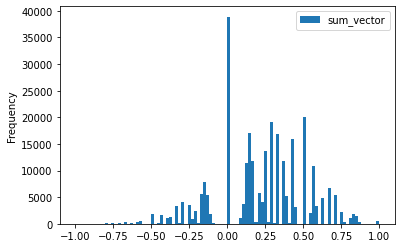

In [33]:
df = pd.DataFrame(result_list, columns=["date", "text", "tokened_text", "vector", "sum_vector"])
ax = df.plot.hist(by='sum_vector', bins=100)

In [34]:
for i in range (0, 100):
    print(output[i])

14-12-2020;В МЭР рассказали о проблемах в реализации совместных проектов с Кубой ;['в', 'мэр', 'рассказать', 'проблема', 'реализация', 'совместный', 'проект', 'куба'];[];0.5

14-12-2020;В Москве отметили снижение числа безработных ;['в', 'москва', 'отметить', 'снижение', 'число', 'безработный'];[];-0.16666666666666666

14-12-2020;Дерипаска дважды за день раскритиковал политику ЦБ в отношении аграриев ;['дерипаск', 'дважды', 'день', 'раскритиковать', 'политика', 'цб', 'отношение', 'аграрий'];[];-0.125

14-12-2020;Цены на сахар и масло ограничат до конца марта ;['цена', 'сахар', 'масло', 'ограничить', 'конец', 'март'];[];0.0

14-12-2020;Структура банка "Россия" купила винодельческое предприятие "Массандра" ;['структура', 'банк', 'россия', 'купить', 'винодельческий', 'предприятие', 'массандра'];[];0.0

14-12-2020;Медведев оценил закон об удаленной работе ;['медведев', 'оценить', 'закон', 'удалённый', 'работа'];[];0.6

14-12-2020;Глава МЭР рассказал о мерах стабилизации цен на продукты ;['